In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import rioxarray as rxr
import geopandas as gpd
import warnings
import glob
from matplotlib import pyplot as plt
from statsmodels.graphics.boxplots import violinplot
import matplotlib as mpl
from cartopy import crs as ccrs
from matplotlib import colors
from matplotlib.font_manager import FontProperties

### Exceedance Rates:

In [2]:
def max_runner(index = 705, version = 'new_bc', re = 'true'):
    
    tnr = FontProperties(fname = '/rds/general/user/tk22/home/fonts/times.ttf',
                         size = 12)
    
    mask_h = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                             'wildfires_theo_keeping/live/ensemble_data/'+
                             'mask_conus_2000_2009.nc').mask.to_numpy()

    mask_s = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                             'wildfires_theo_keeping/live/ensemble_data/'+
                             'mask_conus_2075_2084.nc').mask.to_numpy()
    if re == 'true':
        ds_re = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                                'wildfires_theo_keeping/live/ensemble_summaries/'+
                                 f'p_class_B_19900101_20191231_obs_{index}.nc')
    elif re == 'upscaled':
        ds_re = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                                'wildfires_theo_keeping/live/ensemble_summaries/'+
                                 f'p_class_B_19900101_20191231_updown_{index}.nc')
    else:
        return

    #ds_re = ds_re.sel(time = ds_re.time.dt.year >= lower_year)
    #ds_re = ds_re.sel(time = ds_re.time.dt.year <= upper_year)

    ds_re = ds_re.p.resample(time = '1Y').sum()
    ds_re = (ds_re * mask_h).to_dataset()

    ds_re_1 = ds_re.copy(deep = True).sel(time = ds_re.time.dt.year >= 1990)
    ds_re_1 = ds_re_1.sel(time = ds_re_1.time.dt.year <= 1999)
    ds_re_2 = ds_re.copy(deep = True).sel(time = ds_re.time.dt.year >= 2000)
    ds_re_2 = ds_re_2.sel(time = ds_re_2.time.dt.year <= 2009)
    ds_re_3 = ds_re.copy(deep = True).sel(time = ds_re.time.dt.year >= 2010)
    ds_re_3 = ds_re_3.sel(time = ds_re_3.time.dt.year <= 2019)

    gdf = gpd.read_file('/rds/general/user/tk22/home/paper_2/'+
                        'final_figures/us_eco_l1/NA_CEC_Eco_Level1.shp')

    lats = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                           'wildfires_theo_keeping/live/ensemble_summaries/'+
                           'ensemble_prob_proj_loo_none.nc')['latitude'].to_numpy()
    lons = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                           'wildfires_theo_keeping/live/ensemble_summaries/'+
                           'ensemble_prob_proj_loo_none.nc')['longitude'].to_numpy()

    if version == 'old_bc':
        ds_hist = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                                  'wildfires_theo_keeping/live/ensemble_summaries/'+
                                  'ensemble_prob_hist_loo_none.nc')
        ds_hist = ds_hist.rename({'fires':'p'})
        ds_proj = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                                  'wildfires_theo_keeping/live/ensemble_summaries/'+
                                  'ensemble_prob_proj_loo_none.nc')
        ds_proj = ds_proj.rename({'fires':'p'})

    if version == 'new_bc':
        ds_hist = xr.open_mfdataset('/rds/general/user/tk22/projects/leverhulme_'+
                                    'wildfires_theo_keeping/live/ensemble_summaries/'+
                                    'annual_fires_705_historical.nc')
        ds_proj = xr.open_mfdataset('/rds/general/user/tk22/projects/leverhulme_'+
                                    'wildfires_theo_keeping/live/ensemble_summaries/'+
                                    'annual_fires_705_projected.nc')

    if version == 'no_bc':
        ds_hist = xr.open_dataset('/rds/general/user/tk22/ephemeral/'+
                                  'ensemble_predictors/p_hist_lentis_705.nc')
        ds_hist = ds_hist.p.resample(time = 'Y').sum().to_dataset()
        ds_hist = ds_hist.interp(latitude = lats, 
                                 longitude = lons, 
                                 method = 'linear')
        ds_proj = xr.open_dataset('/rds/general/user/tk22/ephemeral/'+
                                  'ensemble_predictors/p_proj_lentis_705.nc')
        ds_proj = ds_proj.p.resample(time = 'Y').sum().to_dataset()
        ds_proj = ds_proj.interp(latitude = lats, 
                                 longitude = lons, 
                                 method = 'linear')

    ds_hist['p'] = mask_h * ds_hist['p']
    ds_proj['p'] = mask_h * ds_proj['p']

    gdf = gdf.to_crs(crs = "EPSG:4326")
    ds_hist = ds_hist.rio.write_crs("EPSG:4326")
    ds_proj = ds_proj.rio.write_crs("EPSG:4326")
    ds_re_1 = ds_re_1.rio.write_crs("EPSG:4326")
    ds_re_2 = ds_re_2.rio.write_crs("EPSG:4326")
    ds_re_3 = ds_re_3.rio.write_crs("EPSG:4326")

    valid_samples = {'Eastern Temperate Forests': ['EASTERN TEMPERATE FORESTS',
                                                   'TROPICAL WET FORESTS'],
                     'Great Plains': ['GREAT PLAINS'],
                     'Marine West Coast Forest': ['MARINE WEST COAST FOREST'],
                     'Mediterranean California': ['MEDITERRANEAN CALIFORNIA'],
                     'North American Deserts': ['NORTH AMERICAN DESERTS'],
                     'Northern Forests': ['NORTHERN FORESTS'],
                     'Northwestern Forested Mountains': ['NORTHWESTERN FORESTED MOUNTAINS'],
                     'Taiga': ['TAIGA','HUDSON PLAIN'],
                     'Temperate Sierras': ['SOUTHERN SEMIARID HIGHLANDS',
                                           'TEMPERATE SIERRAS'],
                     'Tundra': ['TUNDRA']}

    output_hist = dict()
    output_proj = dict()
    output_re_1 = dict()
    output_re_2 = dict()
    output_re_3 = dict()

    for key in valid_samples.keys():
        print(key)
        sample_gdf = gdf[[x in valid_samples[key] for x in gdf.NA_L1NAME ]]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                sample_ds_hist = ds_hist.rio.clip(sample_gdf.geometry.values, sample_gdf.crs)
                sample_ds_proj = ds_proj.rio.clip(sample_gdf.geometry.values, sample_gdf.crs)
                sample_ds_re_1 = ds_re_1.rio.clip(sample_gdf.geometry.values, sample_gdf.crs)
                sample_ds_re_2 = ds_re_2.rio.clip(sample_gdf.geometry.values, sample_gdf.crs)
                sample_ds_re_3 = ds_re_3.rio.clip(sample_gdf.geometry.values, sample_gdf.crs)

                output_hist[key] = sample_ds_hist
                output_proj[key] = sample_ds_proj
                output_re_1[key]   = sample_ds_re_1
                output_re_2[key]   = sample_ds_re_2
                output_re_3[key]   = sample_ds_re_3
            except:
                pass

    colour_picker = {'Eastern Temperate Forests': '#b4b867',
                     'Great Plains': '#dfb147',
                     'Marine West Coast Forest': '#215d88',
                     'Mediterranean California': '#f7e090',
                     'North American Deserts': '#be8039',
                     'Northern Forests': '#73a57e',
                     'Northwestern Forested Mountains': '#306f48',
                     'Taiga': '#91c0a8',
                     'Temperate Sierras': '#e6c84a',
                     'Tundra': '#bad7d5'}

    plot_order = ['Marine West Coast Forest', 'Mediterranean California',
                  'Northwestern Forested Mountains', 'North American Deserts', 
                  'Temperate Sierras', 'Great Plains', 'Northern Forests',
                  'Eastern Temperate Forests']

    fig = plt.figure(layout = "constrained", figsize = (10,5))
    gs = mpl.gridspec.GridSpec(3, 6, figure = fig)

    ax1 = fig.add_subplot(gs[:2,:])
    x_points = np.linspace(0,3.5,8)
    for i,key in enumerate(plot_order):

        hist_yrs = output_hist[key].p.mean(
            dim = ['latitude','longitude']).max(
            dim = 'time').to_numpy().flatten()
        proj_yrs = output_proj[key].p.mean(
            dim = ['latitude','longitude']).max(
            dim = 'time').to_numpy().flatten()
        re_yrs_1   = output_re_1[key].p.mean(
            dim = ['latitude','longitude']).max(
            dim = 'time').to_numpy().flatten()
        re_yrs_2   = output_re_2[key].p.mean(
            dim = ['latitude','longitude']).max(
            dim = 'time').to_numpy().flatten()
        re_yrs_3   = output_re_3[key].p.mean(
            dim = ['latitude','longitude']).max(
            dim = 'time').to_numpy().flatten()

        hist_median = np.median(hist_yrs)

        hist_yrs = hist_yrs / hist_median
        proj_yrs = proj_yrs / hist_median
        re_yrs_1 = re_yrs_1 / hist_median
        re_max_1 = np.max(re_yrs_1)
        re_yrs_2 = re_yrs_2 / hist_median
        re_max_2 = np.max(re_yrs_2)
        re_yrs_3 = re_yrs_3 / hist_median
        re_max_3 = np.max(re_yrs_3)

        c = colour_picker[key]
        violinplot([hist_yrs], positions = [x_points[i]], ax = ax1,
                   show_boxplot = False, side = 'left',
                   plot_opts = {'violin_fc': c, 'violin_width': 1,
                                'violin_lw': 0, 'violin_alpha': 1})
        violinplot([proj_yrs], positions = [x_points[i]], ax = ax1,
                   show_boxplot = False, side = 'right',
                   plot_opts = {'violin_fc': 'lightgrey', 'violin_width': 1,
                                'violin_lw': 0, 'violin_alpha': 1})
        if i == 0:
            ax1.hlines([re_max_1],[x_points[i]-0.05],[x_points[i]+0.05],
                       colors='#4d131c', zorder=100,
                       label = f'10 Year Maximum (1990-99)')
            ax1.hlines([re_max_2],[x_points[i]-0.05],[x_points[i]+0.05],
                       colors='#911023', zorder=100,
                       label = f'10 Year Maximum (2000-09)')
            ax1.hlines([re_max_3],[x_points[i]-0.05],[x_points[i]+0.05],
                       colors='#ed092b', zorder=100,
                       label = f'10 Year Maximum (2010-19)')
        else:
            ax1.hlines([re_max_1],[x_points[i]-0.05],[x_points[i]+0.05],
                       colors='#4d131c', zorder=100)
            ax1.hlines([re_max_2],[x_points[i]-0.05],[x_points[i]+0.05],
                       colors='#911023', zorder=100)
            ax1.hlines([re_max_3],[x_points[i]-0.05],[x_points[i]+0.05],
                       colors='#ed092b', zorder=100)

    ax1.set_xlim((-0.25,3.75))
    ax1.set_ylim((0.4,20))
    ax1.set_yscale('log')
    ax1.set_yticks([0.3,1,3,10], ['30%','100%','300%','1000%'], font = tnr)
    ax1.set_ylim((0.3,10))
    ax1.set_xticks([])
    ax1.legend(loc = 'upper left', labelspacing = 0.2, prop = tnr)

    ax1.grid(axis = 'y', which = 'major', linestyle = '--')
    ax1.set_ylabel('Ratio with Ensemble 10-Year Maximum\nRelative to Ecoregion Median', font = tnr)
    ax1.set_title(('Probability Distributions of  Ensemble 10-Year Maximum'), font = tnr)

    ax2 = fig.add_subplot(gs[2,:2], projection = ccrs.PlateCarree())
    ax2.grid(False)
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    ax2.set_xlim(-125, -67)
    ax2.set_ylim(24, 50)
    for i,key in enumerate(output_hist.keys()):
        ecoregion = output_re_1[key].p[0,:,:]
        cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'ecomap',[colour_picker[key],colour_picker[key]],N=2)
        ax2.pcolormesh(ecoregion.longitude.data, ecoregion.latitude.data,
                       ecoregion, cmap = cmap, transform = ccrs.PlateCarree())
    ax2.axis('off')


    ax3 = fig.add_subplot(gs[2,2:])
    for k in plot_order + ['With +2°C Warming']:
        if k == 'With +2°C Warming':
            color = 'lightgrey'
        else:
            color = colour_picker[k]
        ax3.scatter([1e4], [1e4], marker = 's', color = color, label = k)

    ax3.set_ylim((0,1))
    ax3.set_xlim((0,1))
    ax3.legend(loc = 'center', prop = tnr, labelspacing = 0.3, markerscale = 1.4, ncol = 2)
    ax3.grid(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)

    plt.tight_layout()
    plt.savefig(('/rds/general/user/tk22/home/paper_2/'+
                 'final_figures/figures/figure_5.jpg'), 
                bbox_inches = 'tight', facecolor = 'white', dpi = 600)
    plt.show()
    return

Eastern Temperate Forests
Great Plains
Marine West Coast Forest
Mediterranean California
North American Deserts
Northern Forests
Northwestern Forested Mountains
Taiga
Temperate Sierras
Tundra


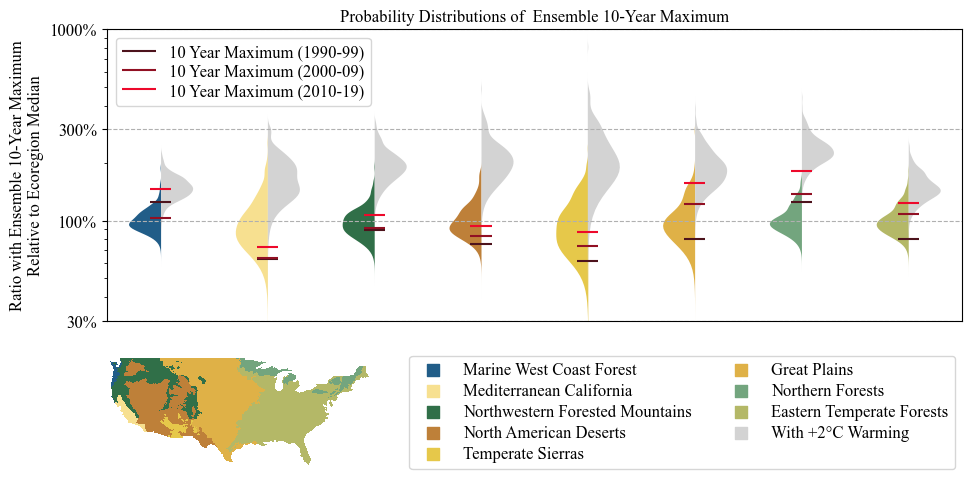

In [3]:
max_runner(index = 705, version = 'new_bc', re = 'true')